,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808
9,1,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808


Training rows: 103, Testing rows: 26
Using XGBoost for modeling.
Train MAE: 4.57 Train RMSE: 5.66
Test  MAE: 5794585.26 Test  RMSE: 12330328.04
Predictions saved to /mnt/data/walmart_sales_predictions.csv


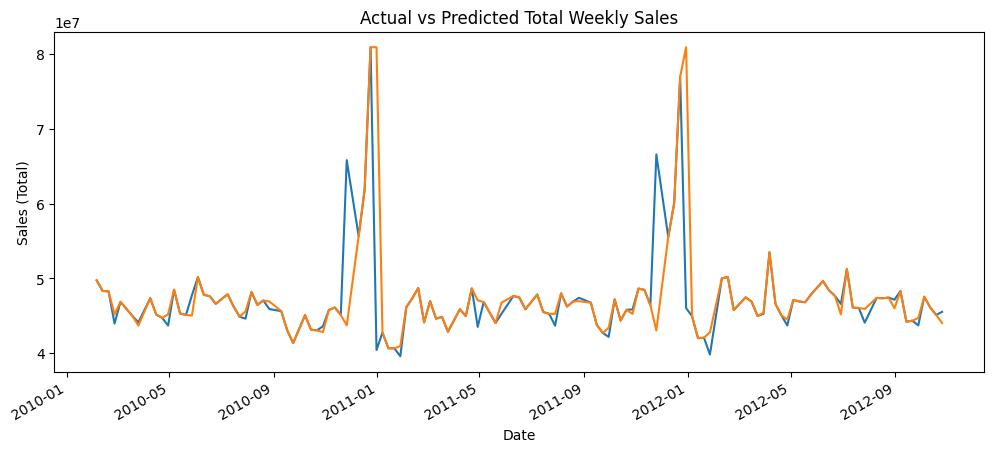

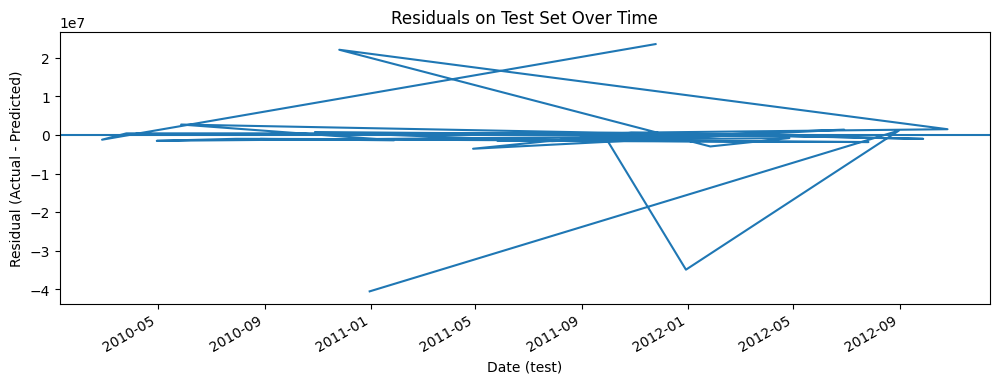

,Date,Actual,Predicted
109,2012-06-08,49651171.78,49651176.0
110,2012-06-15,48412110.70,48412112.0
111,2012-06-22,47668284.97,47668280.0
112,2012-06-29,46597112.12,45195936.0
113,2012-07-06,51253021.88,51253028.0
114,2012-07-13,46099732.10,46099736.0
115,2012-07-20,46059543.45,46059540.0
116,2012-07-27,44097154.97,45917360.0
117,2012-08-10,47403451.04,47403452.0
118,2012-08-17,47354452.05,47354456.0


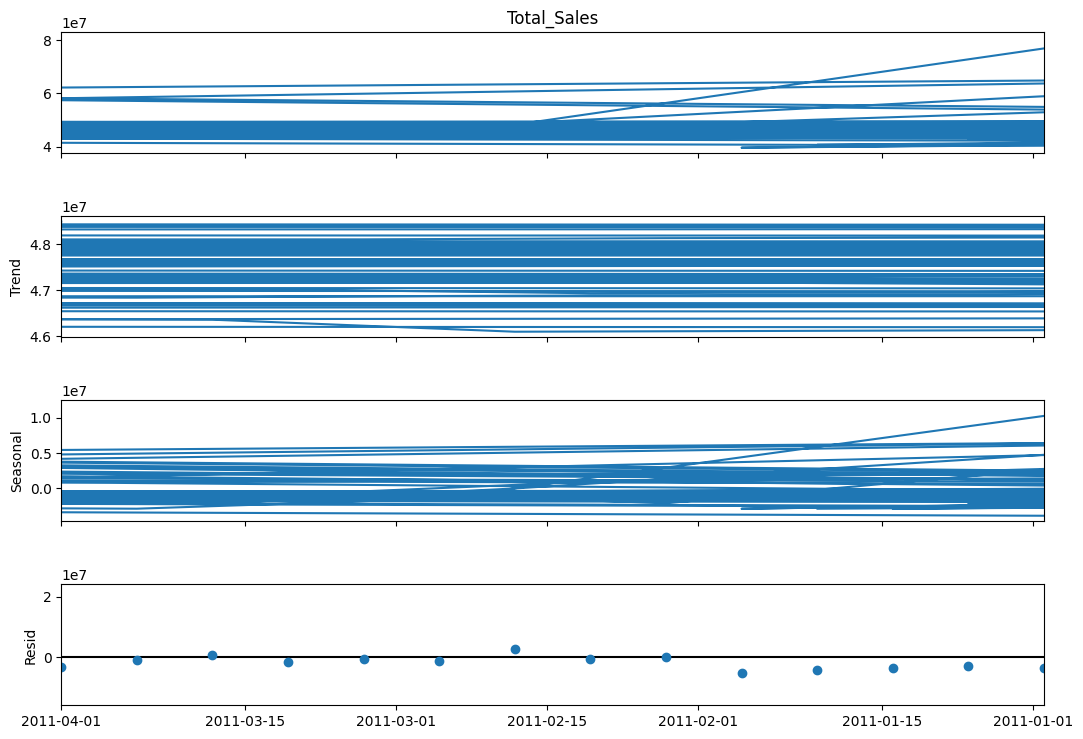

TimeSeriesSplit CV MAEs: [3296974.22, 1809190.01, 1308464.86, 4097291.34, 4896202.69]
Average CV MAE: 3081624.62


,dataset_rows,model_used,train_rows,test_rows,train_MAE,test_MAE,train_RMSE,test_RMSE
0,6435,XGBRegressor,103,26,4.57,5794585.26,5.66,12330328.04


[Download the predictions CSV](/mnt/data/walmart_sales_predictions.csv)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
# from caas_jupyter_tools import display_dataframe_to_user # Removed this import

fp = "/content/Walmart Data Analysis and Forcasting.csv"

# Read dataset
try:
    df = pd.read_csv(fp, parse_dates=['Date'], dayfirst=False, encoding='utf-8')
except Exception:
    try:
        df = pd.read_csv(fp, parse_dates=['Date'], dayfirst=False, encoding='latin1')
    except Exception as e:
        raise RuntimeError(f"Failed to read CSV: {e}")

# Replaced with display(df.head(10))
display(df.head(10))

# Basic check
expected_cols = ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    print("Warning: The following expected columns are missing from the dataset:", missing)

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# Aggregate across stores to get total weekly sales per date
if 'Weekly_Sales' in df.columns:
    df_agg = df.groupby('Date', as_index=False)['Weekly_Sales'].sum().rename(columns={'Weekly_Sales':'Total_Sales'})
else:
    # fallback if column name different
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        df_agg = df.groupby('Date', as_index=False)[numeric_cols[0]].sum().rename(columns={numeric_cols[0]:'Total_Sales'})
    else:
        raise RuntimeError("No numeric sales column found to aggregate.")

# Convert 'Date' column to datetime in df_agg
df_agg['Date'] = pd.to_datetime(df_agg['Date'], format='%d-%m-%Y')

# Create time features
df_agg['day'] = df_agg['Date'].dt.day
df_agg['month'] = df_agg['Date'].dt.month
df_agg['year'] = df_agg['Date'].dt.year
df_agg['weekofyear'] = df_agg['Date'].dt.isocalendar().week.astype(int)
df_agg['dayofweek'] = df_agg['Date'].dt.dayofweek

# Lags and rolling means
lags = [1,2,3,4,7,14]
for l in lags:
    df_agg[f'lag_{l}'] = df_agg['Total_Sales'].shift(l)

windows = [3,7,14]
for w in windows:
    df_agg[f'roll_mean_{w}'] = df_agg['Total_Sales'].shift(1).rolling(window=w, min_periods=1).mean()

df_model = df_agg.dropna().reset_index(drop=True)

feature_cols = ['day','month','year','weekofyear','dayofweek'] + [f'lag_{l}' for l in lags] + [f'roll_mean_{w}' for w in windows]
X = df_model[feature_cols]
y = df_model['Total_Sales']

# Time-aware split (last 20% test)
split_idx = int(len(df_model)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_train = df_model['Date'].iloc[:split_idx]
dates_test = df_model['Date'].iloc[split_idx:]

print(f"Training rows: {len(X_train)}, Testing rows: {len(X_test)}")

# Try XGBoost / LightGBM
model = None
try:
    import xgboost as xgb
    model = xgb.XGBRegressor(n_estimators=200, random_state=42, n_jobs=1)
    print("Using XGBoost for modeling.")
except Exception:
    try:
        import lightgbm as lgb
        model = lgb.LGBMRegressor(n_estimators=200, random_state=42, n_jobs=1)
        print("Using LightGBM for modeling.")
    except Exception:
        model = GradientBoostingRegressor(n_estimators=200, random_state=42)
        print("Using GradientBoostingRegressor (sklearn) as fallback.")

# Fit
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

def rmse(a,b): return np.sqrt(mean_squared_error(a,b))
train_mae = mean_absolute_error(y_train, pred_train)
test_mae = mean_absolute_error(y_test, pred_test)
train_rmse = rmse(y_train, pred_train)
test_rmse = rmse(y_test, pred_test)

print("Train MAE:", round(train_mae,2), "Train RMSE:", round(train_rmse,2))
print("Test  MAE:", round(test_mae,2), "Test  RMSE:", round(test_rmse,2))

results = pd.DataFrame({
    'Date': pd.concat([dates_train, dates_test]).reset_index(drop=True),
    'Actual': pd.concat([y_train, y_test]).reset_index(drop=True),
    'Predicted': np.concatenate([pred_train, pred_test])
}).sort_values('Date').reset_index(drop=True)

out_fp = "/mnt/data/walmart_sales_predictions.csv"
results.to_csv(out_fp, index=False)
print(f"Predictions saved to {out_fp}")

# Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(results['Date'], results['Actual'])
plt.plot(results['Date'], results['Predicted'])
plt.xlabel("Date")
plt.ylabel("Sales (Total)")
plt.title("Actual vs Predicted Total Weekly Sales")
plt.gcf().autofmt_xdate()
plt.show()

# Residuals on test set
residuals = y_test.values - pred_test
plt.figure(figsize=(12,4))
plt.plot(dates_test, residuals)
plt.axhline(0)
plt.xlabel("Date (test)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals on Test Set Over Time")
plt.gcf().autofmt_xdate()
plt.show()

# Replaced with display(results.tail(20))
display(results.tail(20))

# Bonus: rolling averages included. Try seasonal decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    series = df_agg.set_index('Date')['Total_Sales']
    # Guess period by weekly pattern if data weekly: period=52 (yearly) if weekly points
    decomposed = seasonal_decompose(series, model='additive', period=52, extrapolate_trend='freq')
    fig = decomposed.plot()
    fig.set_size_inches(12,8)
    plt.show()
except Exception as e:
    print("Seasonal decomposition skipped (statsmodels may not be installed):", e)

# TimeSeriesSplit CV
tscv = TimeSeriesSplit(n_splits=5)
cv_maes = []
for train_idx, val_idx in tscv.split(X):
    try:
        if 'XGB' in str(type(model)):
            cv_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=1)
        elif 'LGBM' in str(type(model)):
            cv_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=1)
        else:
            cv_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    except Exception:
        cv_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    cv_model.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred_val = cv_model.predict(X.iloc[val_idx])
    cv_maes.append(mean_absolute_error(y.iloc[val_idx], pred_val))

print("TimeSeriesSplit CV MAEs:", [round(x,2) for x in cv_maes])
print("Average CV MAE:", round(np.mean(cv_maes),2))

summary = pd.DataFrame({
    'dataset_rows': [len(df)],
    'model_used': [type(model).__name__],
    'train_rows': [len(X_train)],
    'test_rows': [len(X_test)],
    'train_MAE': [round(train_mae,2)],
    'test_MAE': [round(test_mae,2)],
    'train_RMSE': [round(train_rmse,2)],
    'test_RMSE': [round(test_rmse,2)]
})
# Replaced with display(summary)
display(summary)

print(f"[Download the predictions CSV]({out_fp})")